Notes : Les données utilisées lors de ce projet sont des données financières très sensibles. Pour pouvoir les utiliser dans ce projet OPC, les données ont été falsifier volontairement. Le notebook a été fait à titre indicatif pour montrer la démarche de recherche. Les résultats sont faux.

# Import Bibliotéques

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
import time
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
data = pd.read_excel ("Data.xlsx")

In [3]:
data

,PERIMETRE,PGEN,RISK,PERIODE_COMPTABLE,PRODUIT,DELEGATAIRE,DISTRIBUTEUR,FICHIER_SOURCE,FLUX,MONTANT,...,NBR OCC PGEN X MONTANT X PERIODE,TRANCHE MONTANT,MONTANT PRIMES,MONTANT SINISTRE,FREQUENCE SINISTRE,FREQUENCE SINISTRE REMBOURSE,NOMBRE LIGNES DISTRIBUTEUR,NOMBRE LIGNES RISK,S/P moyenne glissante,ANOMALIE
0,1,0,12,2020-01-01,840,5,15,737,0,128.772107,...,1,3.246574,0.0,128.772107,16.232869,0.0,1676,2287,NaN,0
1,1,0,12,2020-01-01,840,5,19,737,0,100.447906,...,1,2.759406,0.0,100.447906,13.797031,0.0,1058,2287,NaN,0
2,1,0,12,2020-01-01,840,5,15,737,0,191.482344,...,1,3.186911,0.0,191.482344,12.110261,0.0,1676,2287,NaN,0
3,1,0,12,2020-01-01,840,5,19,737,0,218.846947,...,1,4.376064,0.0,218.846947,23.630744,0.0,1058,2287,NaN,0
4,1,0,12,2020-01-01,840,5,15,737,0,528.032684,...,1,3.175143,0.0,528.032684,17.780803,0.0,1676,2287,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46396,0,191,15,2021-10-01,895,10,25,1024,0,0.000000,...,2,0.622225,0.0,0.000000,35.466841,0.0,5453,569,NaN,1
46397,0,191,15,2021-11-01,893,10,25,1013,0,0.000000,...,2,0.632884,0.0,0.000000,36.074393,0.0,5453,569,NaN,1
46398,0,191,15,2021-11-01,895,10,25,1025,0,0.000000,...,2,0.738797,0.0,0.000000,42.111444,0.0,5453,569,NaN,1
46399,0,191,15,2021-12-01,893,10,25,1014,0,0.000000,...,2,0.655266,0.0,0.000000,37.350153,0.0,5453,569,inf,1


# Phase Exploration de la données

([<matplotlib.patches.Wedge at 0x19f950d6770>,
 [Text(-1.0583784562108272, 0.2997249462904057, '0'),
  Text(1.0583784491952581, -0.2997249710635411, '1')],
 [Text(-0.5772973397513602, 0.16348633434022125, '91.2%'),
  Text(0.5772973359246862, -0.16348634785284058, '8.8%')])

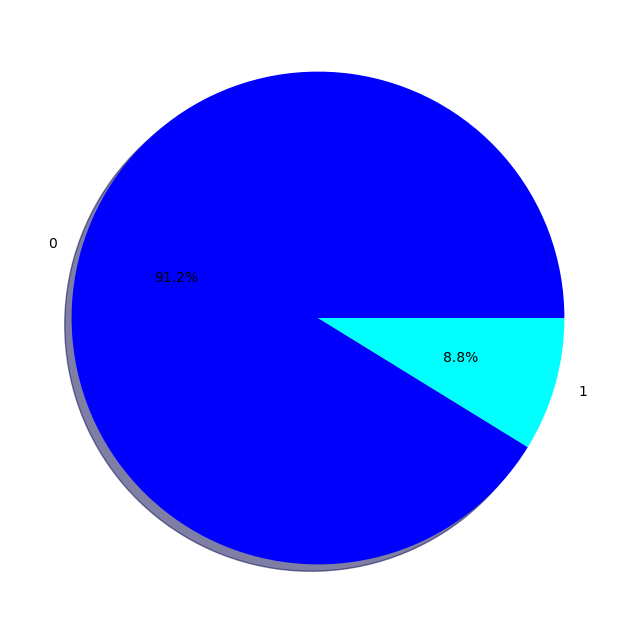

In [4]:
df_data_1 = pd.DataFrame(data= data["ANOMALIE"].value_counts())
plt.figure (figsize = (10,8))
color = ["blue","cyan"]
plt.pie(data =df_data_1 , x ="ANOMALIE",colors = color,  labels =df_data_1 .index ,autopct='%.1f%%' ,shadow = True)

In [5]:
def taux_remplissage(data):
    
    """
    Voir les valeurs manquantes  et le taux de remplissage des données
    
    """
    var_dict = {} ## Création d'un dictionnaire permettant de stocker les 
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["% du dataset complet", "Nombre de valeurs manquantes"]).sort_values(by="% du dataset complet", ascending=False)

In [6]:
taux_remplissage(data)

,% du dataset complet,Nombre de valeurs manquantes
PERIMETRE,100.00,0
Presence_Risk_Code,100.00,0
NOMBRE LIGNES RISK,100.00,0
NOMBRE LIGNES DISTRIBUTEUR,100.00,0
FREQUENCE SINISTRE REMBOURSE,100.00,0
FREQUENCE SINISTRE,100.00,0
MONTANT SINISTRE,100.00,0
MONTANT PRIMES,100.00,0
TRANCHE MONTANT,100.00,0
NBR OCC PGEN X MONTANT X PERIODE,100.00,0


# Pre traitement

In [7]:
data["N-2/N-3"] = np.absolute(data["MONTANT N-2 PGEN RISK"] / data["MONTANT N-3 PGEN RISK"])
data = data.replace(float('inf'), np.NaN)
data = data.replace(float('-inf'), np.NaN)
data["FREQUENCE SINISTRE"] = data["FREQUENCE SINISTRE"].fillna(0)
data["FLUX_SINISTRES_REMBOURSES"] = data["FLUX_SINISTRES_REMBOURSES"].fillna(0)
data["FLUX_SINISTRES"] = data["FLUX_SINISTRES"].fillna(0)

In [8]:
imp = KNNImputer( n_neighbors=10, weights="distance")
col = ["N-2/N-3",'S/P moyenne glissante',"Taux_Commision","TAXES","MONTANT N-3 PGEN RISK","MONTANT N-2 PGEN RISK","taux_taxe","variation_taux_taxe_M-1","Variation_Taux"]
data[col] = imp.fit_transform(data[col])

In [9]:
col_periode = ['PERIODE_COMPTABLE',"PERIODE_DECLARATION","PERIODE_SURVENANCE"]
max_date =[]
for col in col_periode : 
    data[col] =pd.to_datetime(data[col])
    max_date.append(max(data[col]) + datetime.timedelta(days=1))
data["RECENCE PERIODE_COMPTABLE"] = data["PERIODE_COMPTABLE"].apply(lambda x: (max_date[0] - x).days).fillna(0)
data["RECENCE PERIODE_DECLARATION"] = data["PERIODE_DECLARATION"].apply(lambda x: (max_date[1] - x).days).fillna(0)
data["RECENCE PERIODE_SURVENANCE"] = data["PERIODE_SURVENANCE"].apply(lambda x: (max_date[2] - x).days).fillna(0)

# Exploration de la  données

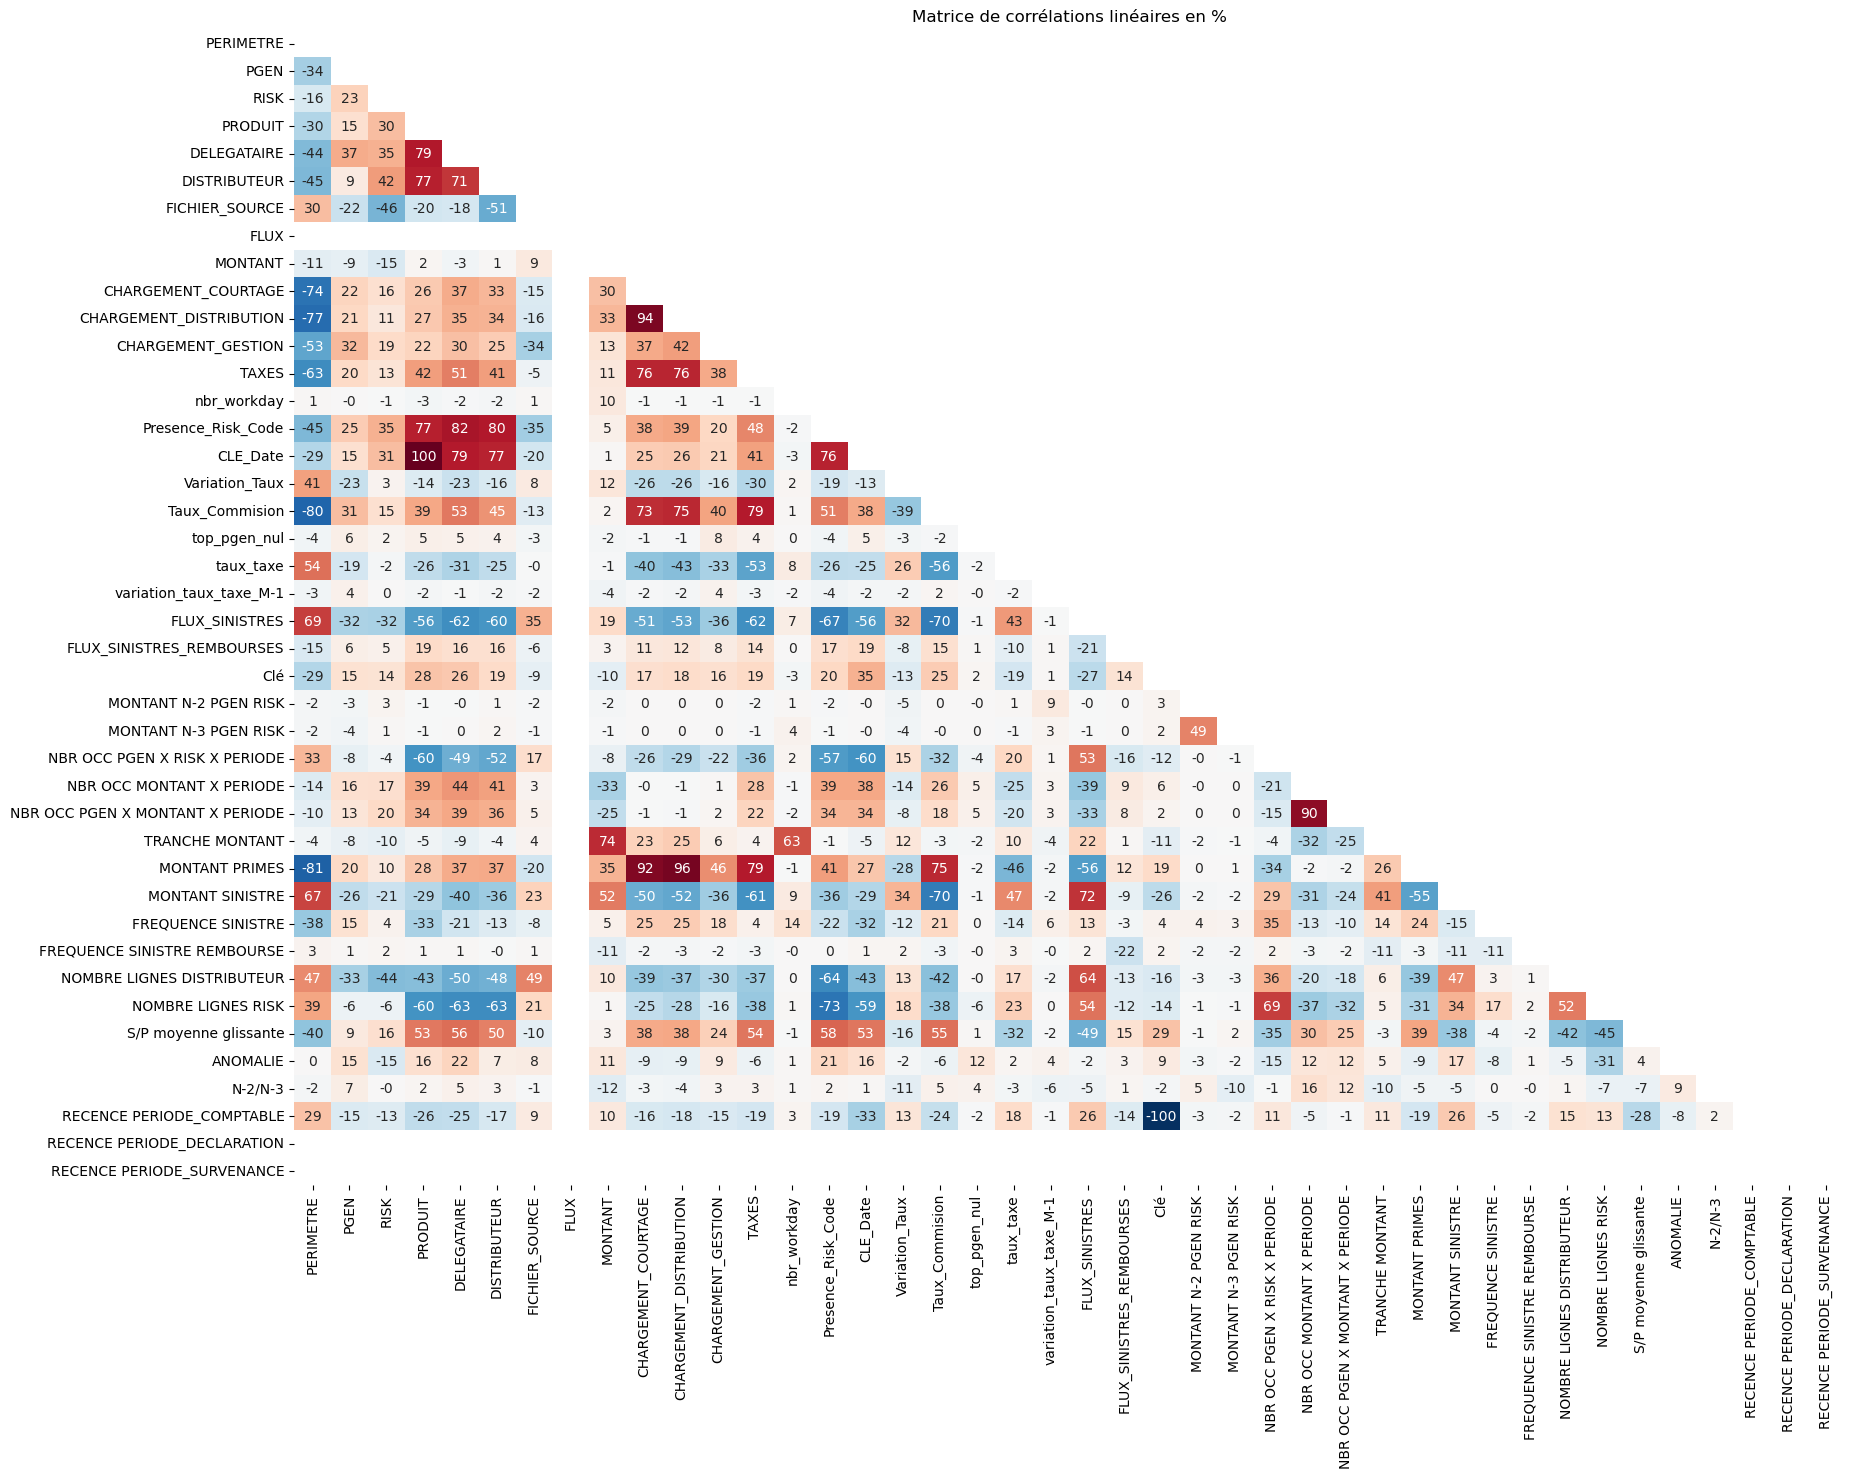

In [10]:
pearson_correlations = data.select_dtypes(['int64', 'float64']).corr(method='spearman')*100.2
cleanning_mask = np.zeros_like(pearson_correlations)
upper_triangle = np.triu_indices_from(pearson_correlations)
cleanning_mask[upper_triangle] = 1
plt.figure(figsize=(20,15))
sns.heatmap(pearson_correlations, cmap="RdBu_r", mask = cleanning_mask, 
           annot = True, fmt=".0f", cbar=False)
plt.title("Matrice de corrélations linéaires en %")
plt.show()

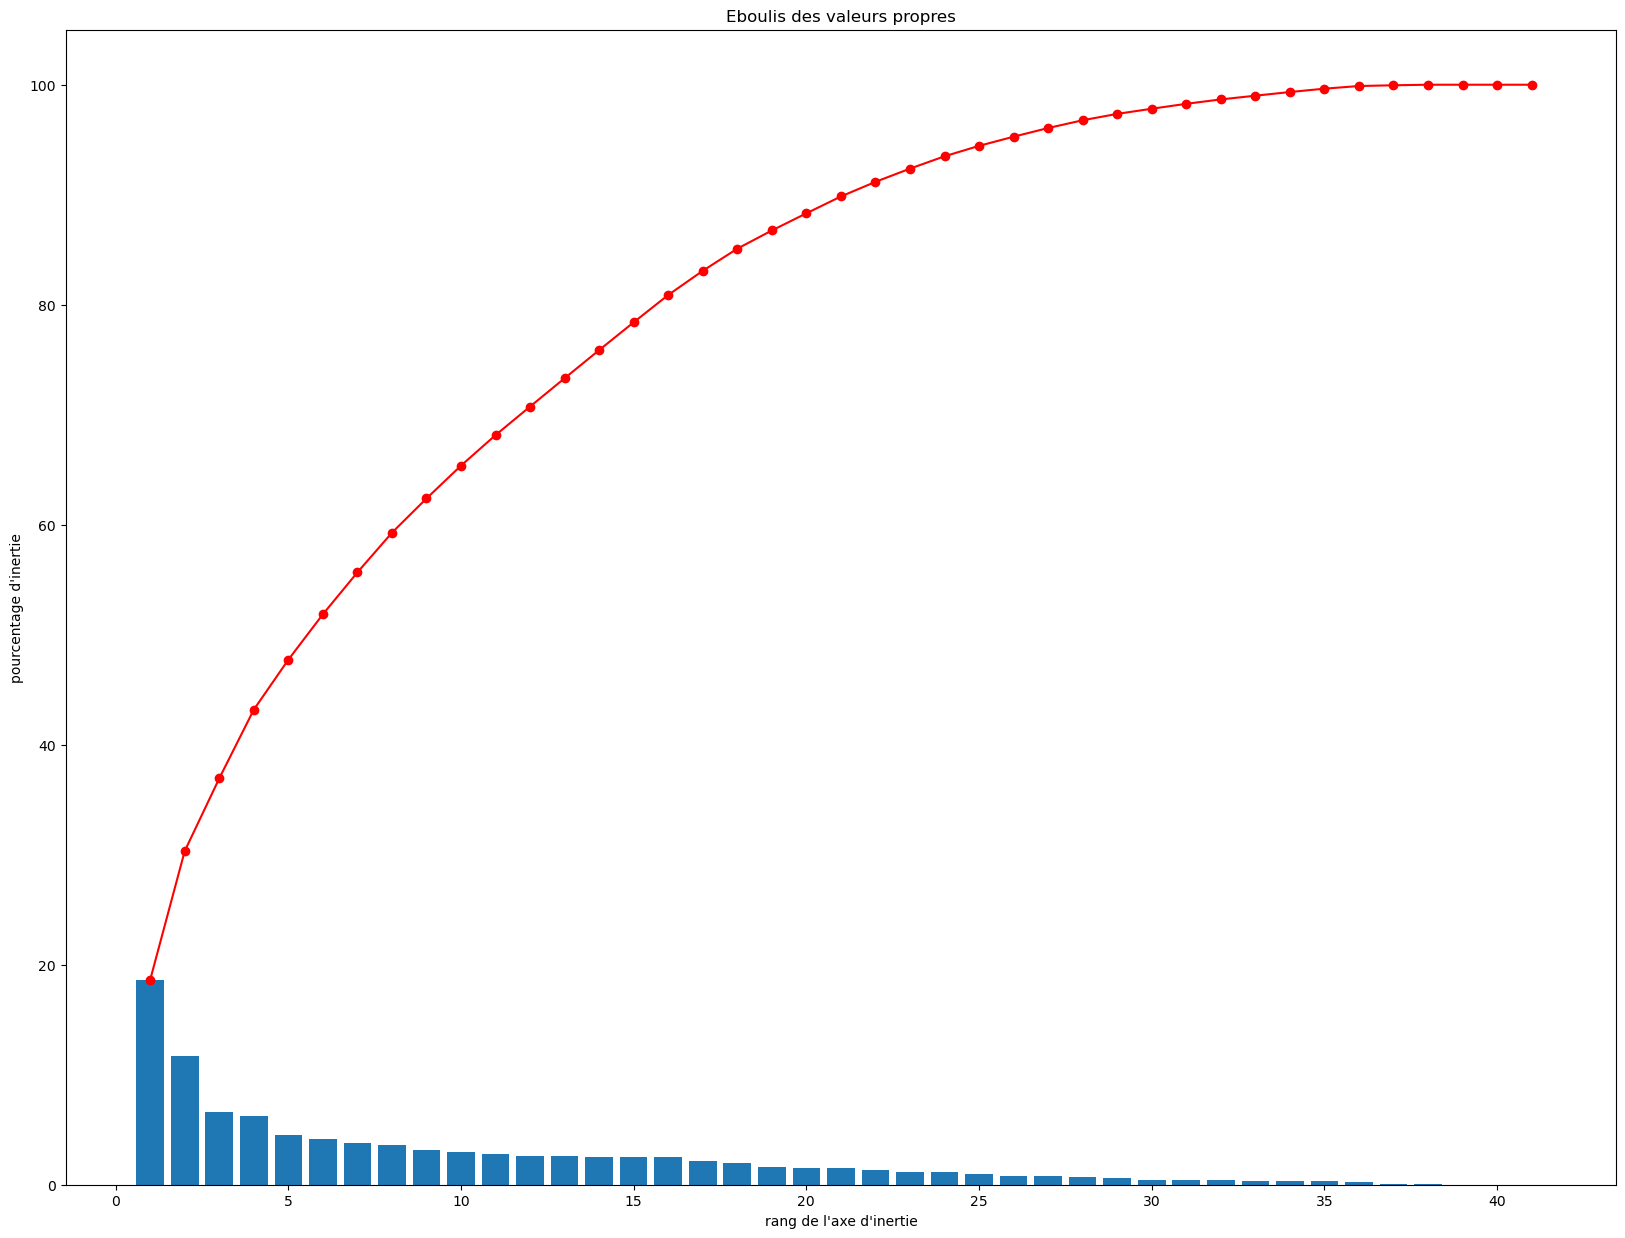

               0
0   1.862117e+01
1   1.170769e+01
2   6.608781e+00
3   6.246648e+00
4   4.542331e+00
5   4.129460e+00
6   3.810084e+00
7   3.604721e+00
8   3.113167e+00
9   2.986976e+00
10  2.774945e+00
11  2.596603e+00
12  2.572989e+00
13  2.558270e+00
14  2.527705e+00
15  2.484026e+00
16  2.197948e+00
17  2.009646e+00
18  1.656087e+00
19  1.560313e+00
20  1.531174e+00
21  1.329124e+00
22  1.200799e+00
23  1.123103e+00
24  9.479632e-01
25  8.335472e-01
26  7.877812e-01
27  7.071784e-01
28  5.787515e-01
29  4.673284e-01
30  4.485512e-01
31  3.988474e-01
32  3.383413e-01
33  3.336999e-01
34  3.053984e-01
35  2.404612e-01
36  6.750626e-02
37  5.088416e-02
38  3.672378e-30
39  7.641947e-32
40  7.641947e-32


In [11]:
from sklearn import decomposition
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data_slf = data.select_dtypes(['int64', 'float64'])
## Appel de la classe PCA
pca = PCA()
pca.fit(data_slf)

sel_feat = data_slf.columns

## Projection des PCA et choix du nombre de composant
filtered_cols = sel_feat

## Récupération des valeurs du dataframe dans une liste
X = data_slf.loc[:, filtered_cols].values

##Sélection des colonnes
features = data_slf.loc[:, filtered_cols].columns

## Choix du nombre de composantes
n_comp = len(sel_feat)-1

##Normaliser les caractéristiques en supprimant la moyenne et en mettant à l'échelle la variance unitaire.
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

##Decomposition en PCA
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

pcs = pca.components_

X_projected = pca.transform(X_scaled)

scree = pca.explained_variance_ratio_*100
scree.cumsum()

def display_scree_plot(pca):
    """
    Fonction qui affiche le graphique ébouli 
    """
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    print(pd.DataFrame(scree))
    
fig, ax = plt.subplots(figsize=(20, 15))    
display_scree_plot(pca)

In [12]:
pcs = pd.DataFrame(pcs)

x_list = range(1, n_comp +1)
list(x_list)

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

round(pcs.T*100,2)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41
PERIMETRE,-23.25,-0.95,33.65,18.82,2.07,-8.24,0.92,15.62,-7.57,20.19,...,-54.91,22.46,-31.02,23.69,19.63,-0.84,-6.90,-0.00,-0.00,0.0
PGEN,13.69,-2.60,-29.16,-5.69,3.94,26.53,0.82,11.05,-27.38,3.21,...,-14.25,-11.25,15.95,17.07,-11.47,0.28,-3.75,-0.00,-0.00,0.0
RISK,10.53,-1.78,-6.86,-14.82,-13.39,6.76,5.13,50.27,-2.92,33.94,...,-0.06,-9.30,8.70,-2.47,-3.91,-0.24,2.30,0.00,-0.00,0.0
PRODUIT,31.55,-8.45,23.86,-2.54,-2.40,-2.36,0.41,5.01,1.90,7.72,...,-6.66,-0.07,26.44,-15.67,-2.26,9.11,-73.29,-0.00,-0.00,0.0
DELEGATAIRE,28.44,-6.57,11.59,11.09,9.05,-0.63,-1.48,-10.02,0.78,5.34,...,17.74,-8.80,-30.32,8.19,33.43,-0.05,-4.24,-0.00,0.00,0.0
DISTRIBUTEUR,24.85,-5.35,18.70,-15.97,-9.80,5.11,1.91,16.39,2.67,-1.05,...,15.11,-15.68,-23.15,20.79,8.27,0.20,1.70,-0.00,-0.00,0.0
FICHIER_SOURCE,-18.61,1.80,7.99,27.21,14.15,-5.37,-3.46,-24.91,6.35,1.77,...,8.16,-2.51,1.64,-0.32,-14.37,-0.53,1.91,-0.00,-0.00,0.0
FLUX,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,34.98,93.68,0.0
MONTANT,10.19,42.77,4.22,5.04,10.62,7.26,1.57,5.70,2.91,-2.64,...,-7.10,-21.68,-9.65,-16.76,-3.92,-36.07,-3.40,66.16,-24.70,0.0
CHARGEMENT_COURTAGE,8.79,31.96,-0.57,2.41,-5.80,-5.30,-1.41,-15.81,21.29,2.76,...,-4.77,32.05,10.09,25.12,4.32,-24.93,-3.10,-0.00,0.00,0.0


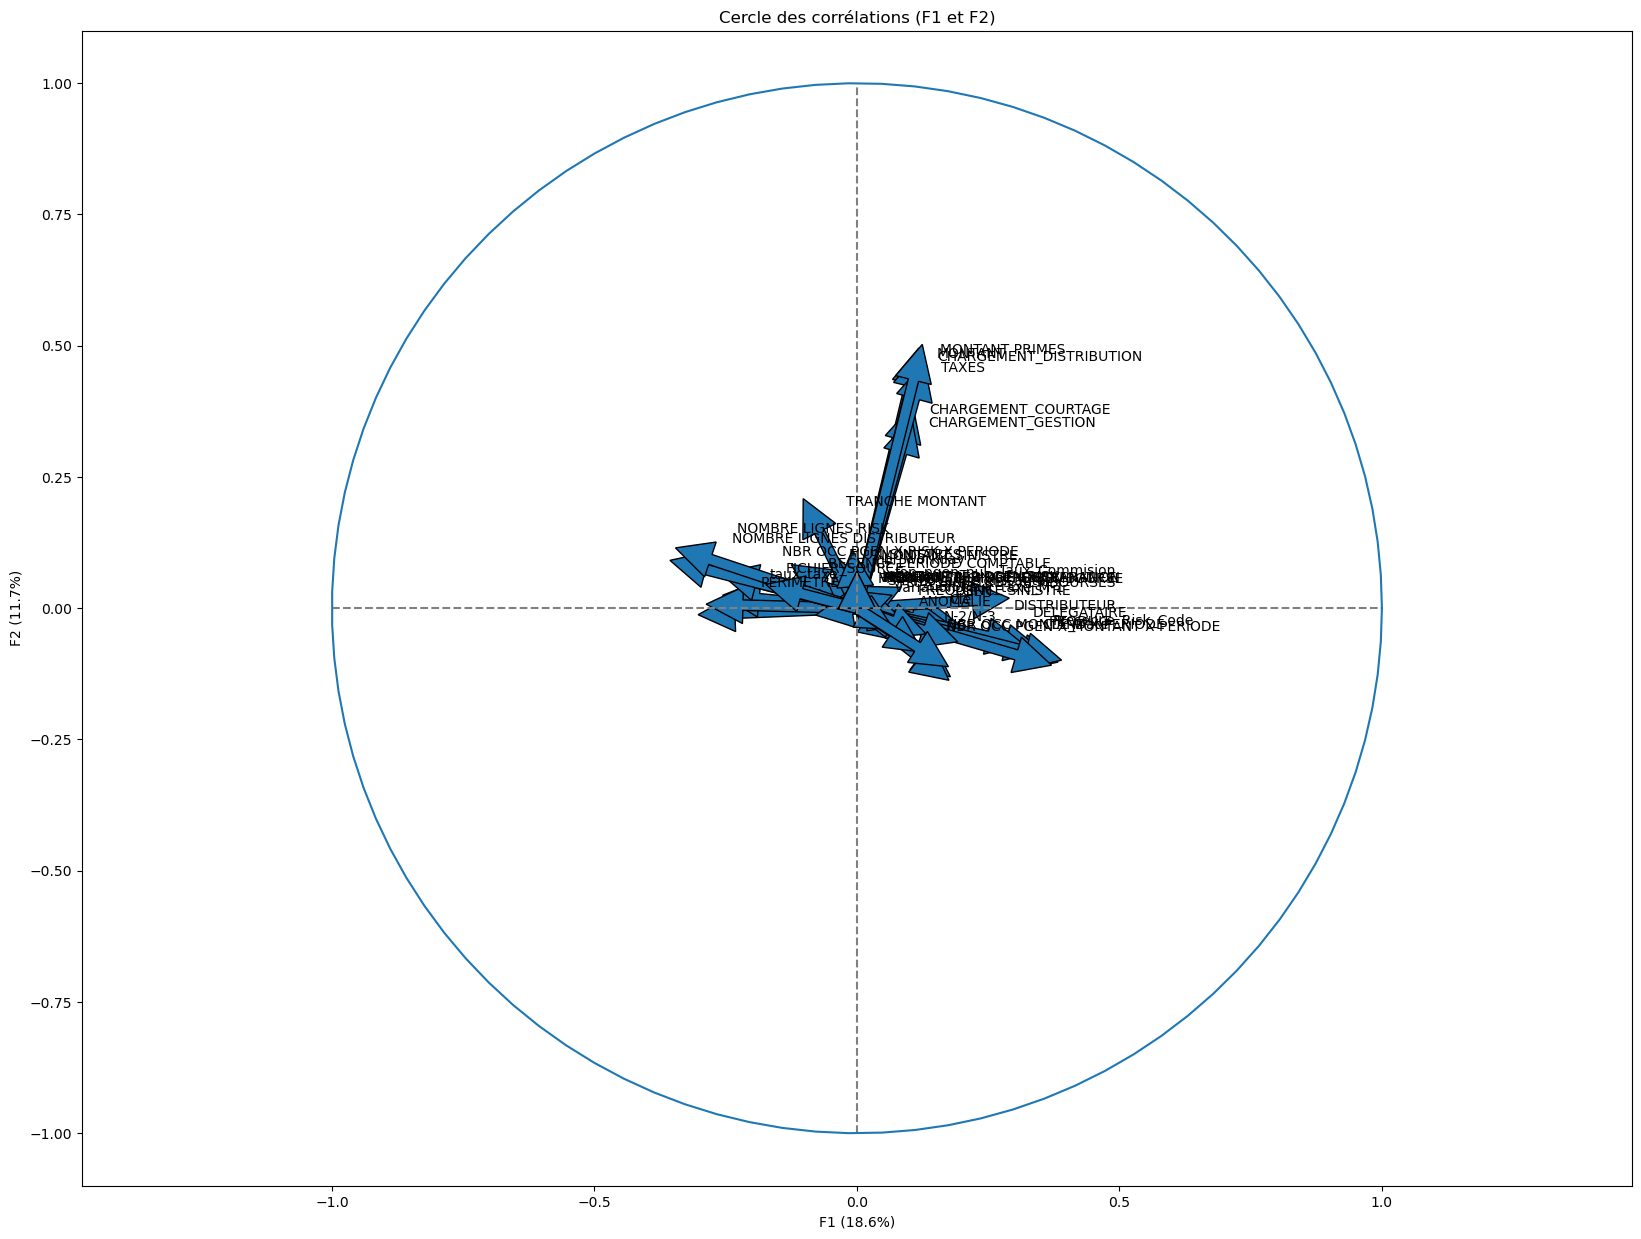

In [13]:
x, y = 0,1

fig, ax = plt.subplots(figsize=(20, 15))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

# Modélisation de la données

In [14]:
X = data.select_dtypes(['int64', 'float64']).drop(columns="ANOMALIE", axis=1)
Y = data["ANOMALIE"]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 100, shuffle=True, stratify = Y)

In [16]:
sel_feat = ['FLUX_SINISTRES', 'MONTANT', 'TAXES', 'nbr_workday','Presence_Risk_Code', 'Variation_Taux', 'Taux_Commision','NBR OCC PGEN X RISK X PERIODE', 'NBR OCC MONTANT X PERIODE','NBR OCC PGEN X MONTANT X PERIODE', 'TRANCHE MONTANT', 'MONTANT PRIMES','MONTANT SINISTRE', 'FREQUENCE SINISTRE','FREQUENCE SINISTRE REMBOURSE', 'NOMBRE LIGNES DISTRIBUTEUR','NOMBRE LIGNES RISK', 'S/P moyenne glissante', 'top_pgen_nul','RECENCE PERIODE_COMPTABLE', 'RECENCE PERIODE_DECLARATION','RECENCE PERIODE_SURVENANCE','N-2/N-3']
data_slf = data[sel_feat].select_dtypes(['int64', 'float64'])

In [17]:
def func_training_model(model, x_train, y_train, nom) :
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(model, x_train, y_train, scoring=scoring, cv=5, return_train_score=True)
    print(f'''Résultats sur les données d'entraînement avec le modèle : {nom}\n''')
    output = sorted(scores.keys())
    model_resume = {}
    for i in range(len(output)):
        model_resume[output[i]] = np.mean(scores[output[i]])
    df_model = pd.DataFrame([model_resume])
    model.fit(x_train, y_train)
    return model, df_model

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
model_dy = DummyClassifier(random_state=1)
training_model_dy, results_model_dy = func_training_model(model_dy, x_train, y_train, "Model Dummy")
results_model_dy

Résultats sur les données d'entraînement avec le modèle : Model Dummy



,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,0.019183,0.020192,0.912155,0.0,0.0,0.0,0.912155,0.0,0.0,0.0


In [20]:
model_RF = RandomForestClassifier(random_state=1)
training_model_RF, results_model_RF = func_training_model(model_RF, x_train, y_train, "Model Random Forest")
results_model_RF

Résultats sur les données d'entraînement avec le modèle : Model Random Forest



,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,6.77665,0.08277,0.998851,0.993397,1.0,0.986912,1.0,1.0,1.0,1.0


In [21]:
model_XGB = GradientBoostingClassifier(random_state=1)
training_model_XGB, results_model_XGB = func_training_model(model_XGB, x_train, y_train, "Model Gradient Boosting")
results_model_XGB

Résultats sur les données d'entraînement avec le modèle : Model Gradient Boosting



,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,23.235818,0.025862,0.994224,0.966049,0.997573,0.936532,0.995295,0.972493,0.999223,0.947171


In [22]:
model_LR = LogisticRegression(random_state=1)
training_model_Ridge, results_model_Ridge = func_training_model(model_LR, x_train, y_train, "Model Logistic Regression")
results_model_Ridge

Résultats sur les données d'entraînement avec le modèle : Model Logistic Regression



,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,0.061,0.011496,0.912155,0.0,0.0,0.0,0.912155,0.0,0.0,0.0


In [23]:
from sklearn.neural_network import MLPClassifier

 
model_MLP = MLPClassifier(hidden_layer_sizes = 4096, solver = "adam", random_state = 1, learning_rate='adaptive', learning_rate_init=0.05  )
training_model_MLP, results_model_MLP = func_training_model(model_MLP, x_train, y_train, "Model MLP")

results_model_MLP

Résultats sur les données d'entraînement avec le modèle : Model MLP



,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,47.833216,0.142699,0.932672,0.607642,0.626157,0.593709,0.935553,0.62081,0.644426,0.601732


In [26]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
params = {          "criterion" : [ "entropy", "log_loss"],
                    "n_estimators": [10, 100],
                     "random_state" : [0] ,
                    "max_depth" : [100,5000],
                    "max_features" : ["sqrt", "log2"]

                   }



In [29]:
model_ = GridSearchCV(estimator = model,
                          param_grid = params,
                          scoring = 'precision',
                          refit = True,
                          cv=5,
                          verbose=3)

model_.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=10, random_state=0;, score=0.998 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=10, random_state=0;, score=1.000 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=10, random_state=0;, score=1.000 total time=   0.4s
[CV 4/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=10, random_state=0;, score=0.995 total time=   0.4s
[CV 5/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=10, random_state=0;, score=1.000 total time=   0.4s
[CV 1/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=100, random_state=0;, score=0.998 total time=   4.2s
[CV 2/5] END criterion=entropy, max_depth=100, max_features=sqrt, n_estimators=100, random_state=0;, score=1.000 total time=   4.1s
[CV 3/5] END criteri

[CV 3/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=10, random_state=0;, score=1.000 total time=   0.3s
[CV 4/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=10, random_state=0;, score=0.995 total time=   0.4s
[CV 5/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=10, random_state=0;, score=1.000 total time=   0.4s
[CV 1/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=100, random_state=0;, score=0.998 total time=   4.0s
[CV 2/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=100, random_state=0;, score=1.000 total time=   4.0s
[CV 3/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=100, random_state=0;, score=1.000 total time=   4.1s
[CV 4/5] END criterion=log_loss, max_depth=5000, max_features=sqrt, n_estimators=100, random_state=0;, score=1.000 total time=   4.0s
[CV 5/5] END criterion=log_loss, max_depth=5000, max_features=sqr

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'log_loss'],
                         'max_depth': [100, 5000],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100], 'random_state': [0]},
             scoring='precision', verbose=3)

In [30]:
print(f" Les meilleurs paramètres sont {model_.best_params_}")


 Les meilleurs paramètres sont {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 100, 'random_state': 0}


In [32]:
model_RF = RandomForestClassifier( criterion= 'entropy', max_depth= 100, max_features= "log2", max_leaf_nodes= 10, n_estimators= 100, random_state= 0)
training_model_RF, results_model_RF = func_training_model(model_RF, x_train, y_train, "Model Random Forest")
results_model_RF

Résultats sur les données d'entraînement avec le modèle : Model Random Forest



,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,train_accuracy,train_f1,train_precision,train_recall
0,2.352343,0.041722,0.980029,0.871692,1.0,0.772646,0.980251,0.87336,0.999788,0.775351
